# Michigan QCEW — Lightcast vs BEA Adjustments & Extensions

This notebook compares **Lightcast core-auto shares** vs **BEA input–output shares** for:
- Historical (adjusted) Michigan QCEW employment by **stage** and **segment**
- Extensions through 2034 using **Moody** and **BLS** growth rates

**Prerequisites**
- Run:
  - `scripts/apply_coreauto_share_and_extend.py`
  - `scripts/apply_bea_share_and_extend.py`


In [1]:

from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

def find_repo_root(markers=("data","scripts")) -> Path:
    here = Path.cwd()
    for p in (here, *here.parents):
        if all((p / m).exists() for m in markers):
            return p
    return here

REPO_ROOT = find_repo_root()
os.chdir(REPO_ROOT)
print("Working dir ->", Path.cwd())

DATA_INTERIM = REPO_ROOT / "data" / "interim"
DATA_PROCESSED = REPO_ROOT / "data" / "processed"
FIG_DIR = REPO_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

LC_SEG_BASE = DATA_INTERIM / "mi_qcew_segment_employment_timeseries_coreauto.csv"
LC_STG_BASE = DATA_INTERIM / "mi_qcew_stage_employment_timeseries_coreauto.csv"
BEA_SEG_BASE = DATA_INTERIM / "mi_qcew_segment_employment_timeseries_bea.csv"
BEA_STG_BASE = DATA_INTERIM / "mi_qcew_stage_employment_timeseries_bea.csv"

LC_SEG_CMP = DATA_PROCESSED / "mi_qcew_segment_employment_timeseries_coreauto_extended_compare.csv"
LC_STG_CMP = DATA_PROCESSED / "mi_qcew_stage_employment_timeseries_coreauto_extended_compare.csv"
BEA_SEG_CMP = DATA_PROCESSED / "mi_qcew_segment_employment_timeseries_bea_extended_compare.csv"
BEA_STG_CMP = DATA_PROCESSED / "mi_qcew_stage_employment_timeseries_bea_extended_compare.csv"

required = [LC_SEG_BASE, LC_STG_BASE, BEA_SEG_BASE, BEA_STG_BASE, LC_SEG_CMP, LC_STG_CMP, BEA_SEG_CMP, BEA_STG_CMP]
missing = [str(p) for p in required if not p.exists()]
if missing:
    raise FileNotFoundError("Missing required inputs:\n- " + "\n- ".join(missing))

lc_seg_base = pd.read_csv(LC_SEG_BASE)
lc_stg_base = pd.read_csv(LC_STG_BASE)
bea_seg_base = pd.read_csv(BEA_SEG_BASE)
bea_stg_base = pd.read_csv(BEA_STG_BASE)

lc_seg_cmp = pd.read_csv(LC_SEG_CMP)
lc_stg_cmp = pd.read_csv(LC_STG_CMP)
bea_seg_cmp = pd.read_csv(BEA_SEG_CMP)
bea_stg_cmp = pd.read_csv(BEA_STG_CMP)

for df in (lc_seg_base, lc_stg_base, bea_seg_base, bea_stg_base, lc_seg_cmp, lc_stg_cmp, bea_seg_cmp, bea_stg_cmp):
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    df.dropna(subset=["year"], inplace=True)
    df["year"] = df["year"].astype(int)

YR_MIN, YR_MAX = 2001, 2034


Working dir -> c:\Users\vasilauskas\GitHub\EV-Transition


In [2]:

def one_point_per_year(df, keys, value_col="employment_qcew", how="sum"):
    df = df.copy()
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    df = df.dropna(subset=["year"]).copy()
    df["year"] = df["year"].astype(int)
    agg = df.groupby(keys + ["year"], as_index=False)[value_col]
    return (agg.sum() if how == "sum" else agg.mean()).sort_values("year")

def first_label(seg_df):
    return seg_df.sort_values(["segment_id","year"]).groupby("segment_id")["segment_name"].first()

def forecast_start(df):
    d = df[(df.get("value_type")=="Forecast") & df.get("year").notna()]
    return int(d["year"].min()) if not d.empty else None


## Stage plots — Lightcast vs BEA (historical + forecasts)

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_compare_stage_downstream_lightcast_vs_bea_2001_2034.png


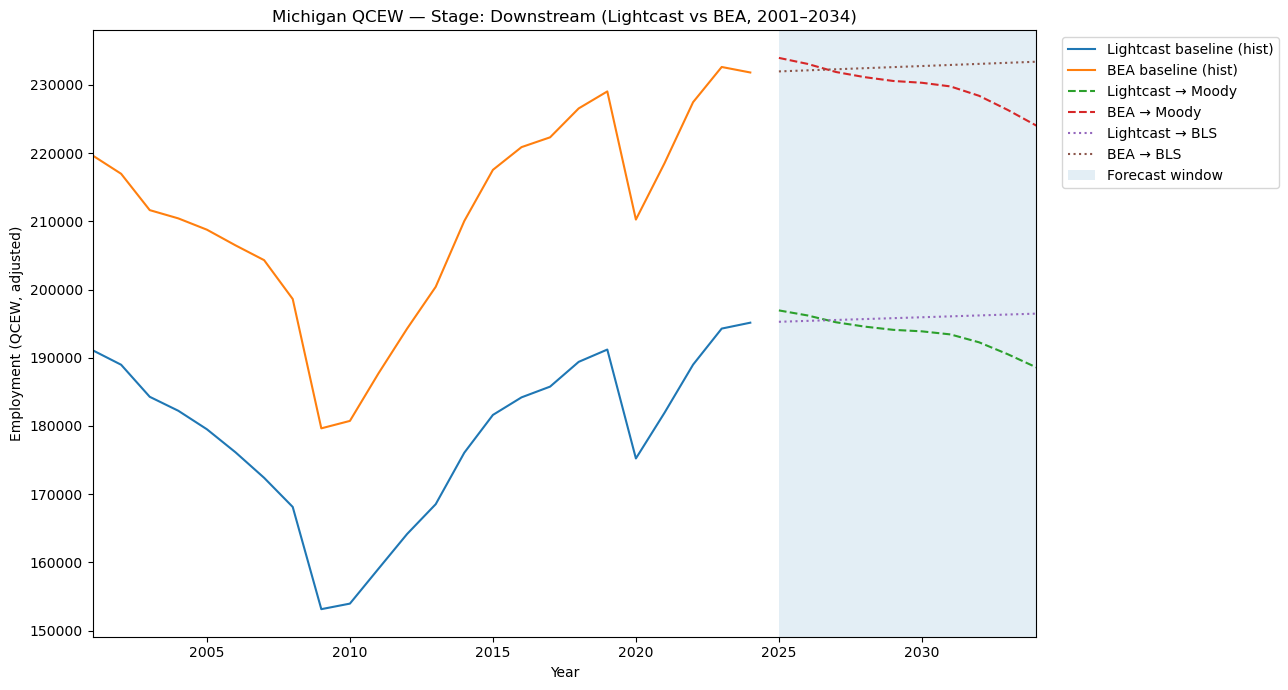

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_compare_stage_oem_lightcast_vs_bea_2001_2034.png


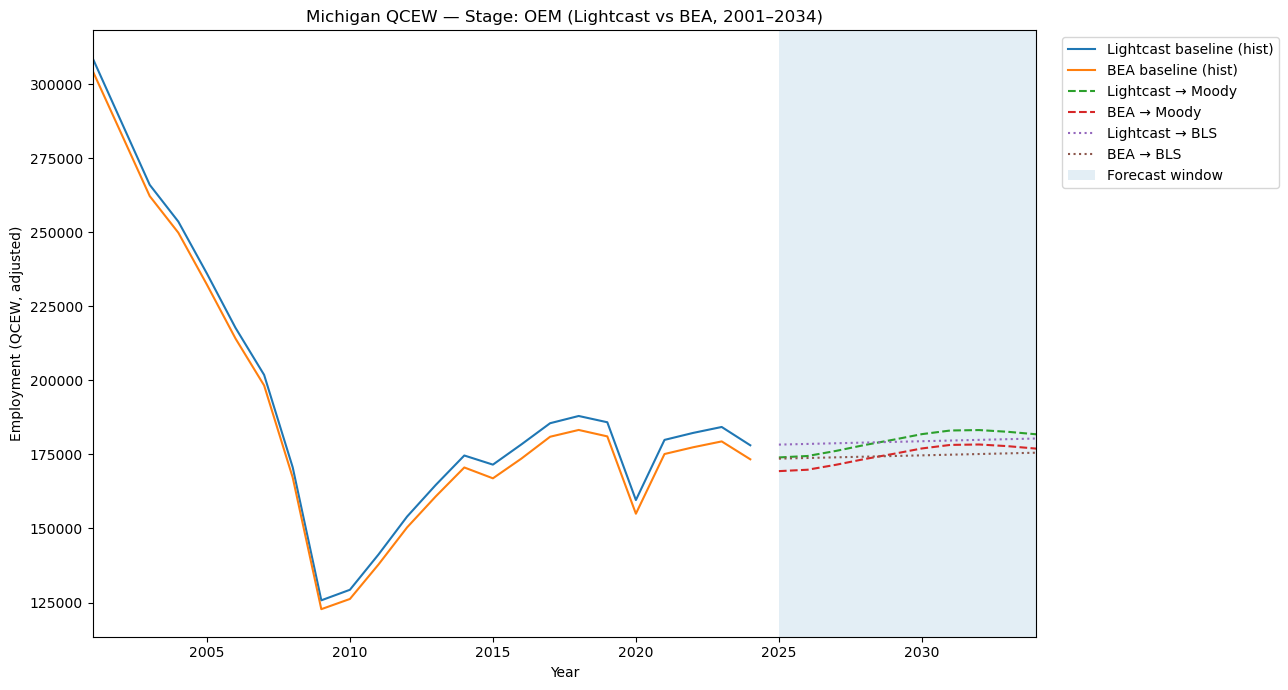

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_compare_stage_upstream_lightcast_vs_bea_2001_2034.png


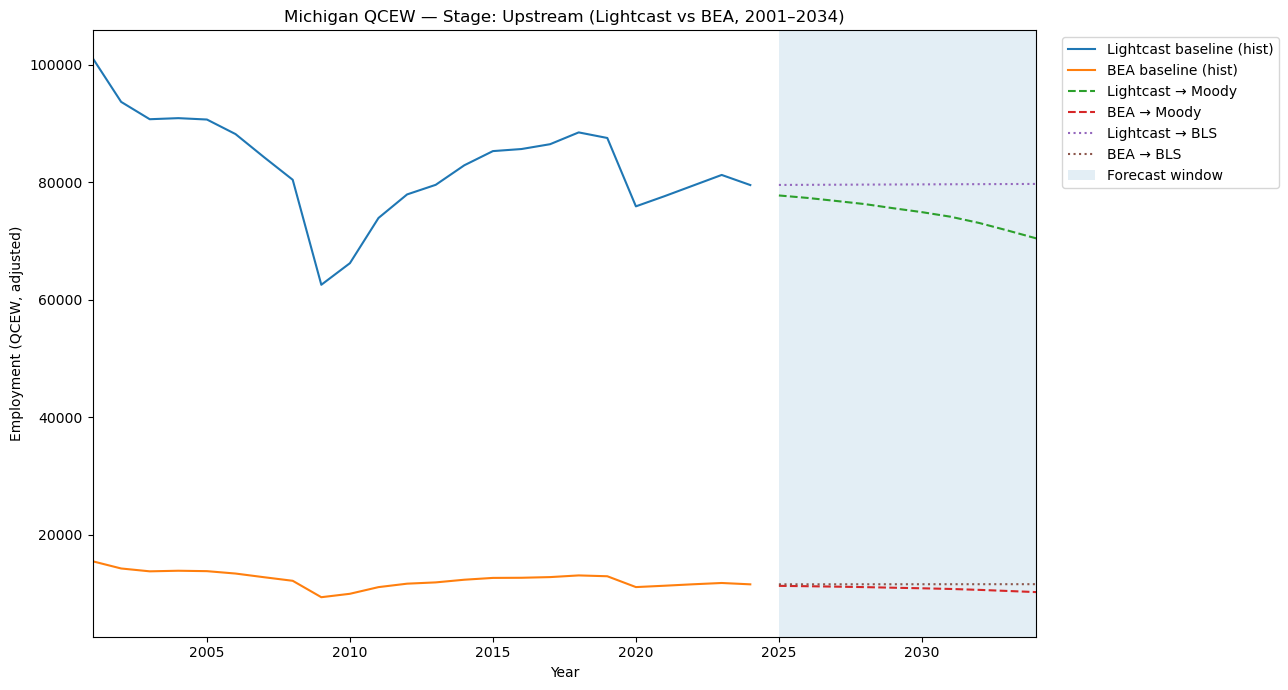

In [3]:

from matplotlib.patches import Patch

def plot_stage_compare(stage_name: str):
    lc_hist = one_point_per_year(lc_stg_base[lc_stg_base["stage"].astype(str).eq(stage_name)], ["stage"])
    bea_hist = one_point_per_year(bea_stg_base[bea_stg_base["stage"].astype(str).eq(stage_name)], ["stage"])

    lc_cmp = lc_stg_cmp[lc_stg_cmp["stage"].astype(str).eq(stage_name)]
    lc_moody = one_point_per_year(lc_cmp[(lc_cmp["value_type"]=="Forecast") & (lc_cmp["forecast_source"]=="Moody")], ["stage"]) if not lc_cmp.empty else pd.DataFrame()
    lc_bls   = one_point_per_year(lc_cmp[(lc_cmp["value_type"]=="Forecast") & (lc_cmp["forecast_source"]=="BLS")],   ["stage"]) if not lc_cmp.empty else pd.DataFrame()

    bea_cmp = bea_stg_cmp[bea_stg_cmp["stage"].astype(str).eq(stage_name)]
    bea_moody = one_point_per_year(bea_cmp[(bea_cmp["value_type"]=="Forecast") & (bea_cmp["forecast_source"]=="Moody")], ["stage"]) if not bea_cmp.empty else pd.DataFrame()
    bea_bls   = one_point_per_year(bea_cmp[(bea_cmp["value_type"]=="Forecast") & (bea_cmp["forecast_source"]=="BLS")],   ["stage"]) if not bea_cmp.empty else pd.DataFrame()

    fig, ax = plt.subplots(figsize=(13,7))
    if not lc_hist.empty:  ax.plot(lc_hist["year"],  lc_hist["employment_qcew"],  label="Lightcast baseline (hist)")
    if not bea_hist.empty: ax.plot(bea_hist["year"], bea_hist["employment_qcew"], label="BEA baseline (hist)")
    if not lc_moody.empty:  ax.plot(lc_moody["year"],  lc_moody["employment_qcew"],  linestyle="--", label="Lightcast → Moody")
    if not bea_moody.empty: ax.plot(bea_moody["year"], bea_moody["employment_qcew"], linestyle="--", label="BEA → Moody")
    if not lc_bls.empty:  ax.plot(lc_bls["year"],  lc_bls["employment_qcew"],  linestyle=":", label="Lightcast → BLS")
    if not bea_bls.empty: ax.plot(bea_bls["year"], bea_bls["employment_qcew"], linestyle=":", label="BEA → BLS")

    starts = [s for s in (forecast_start(lc_cmp), forecast_start(bea_cmp)) if s is not None]
    if starts:
        fstart = max(min(starts), YR_MIN)
        ax.axvspan(fstart, YR_MAX, alpha=0.12, zorder=0)
        handles, labels = ax.get_legend_handles_labels()
        handles.append(Patch(alpha=0.12, label="Forecast window")); labels.append("Forecast window")
        ax.legend(handles, labels, bbox_to_anchor=(1.02,1), loc="upper left")
    else:
        ax.legend(bbox_to_anchor=(1.02,1), loc="upper left")

    ax.set_xlim(YR_MIN, YR_MAX)
    ax.set_xlabel("Year"); ax.set_ylabel("Employment (QCEW, adjusted)")
    ax.set_title(f"Michigan QCEW — Stage: {stage_name} (Lightcast vs BEA, 2001–2034)")
    fig.tight_layout()
    out = FIG_DIR / f"mi_qcew_compare_stage_{stage_name.lower()}_lightcast_vs_bea_2001_2034.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    print("Saved:", out)
    plt.show(); plt.close(fig)

for st in sorted(set(lc_stg_base["stage"].astype(str)).union(set(bea_stg_base["stage"].astype(str)))):
    plot_stage_compare(st)


## Segment plots — Lightcast vs BEA (historical + forecasts)

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_compare_segment_1_lightcast_vs_bea_2001_2034.png


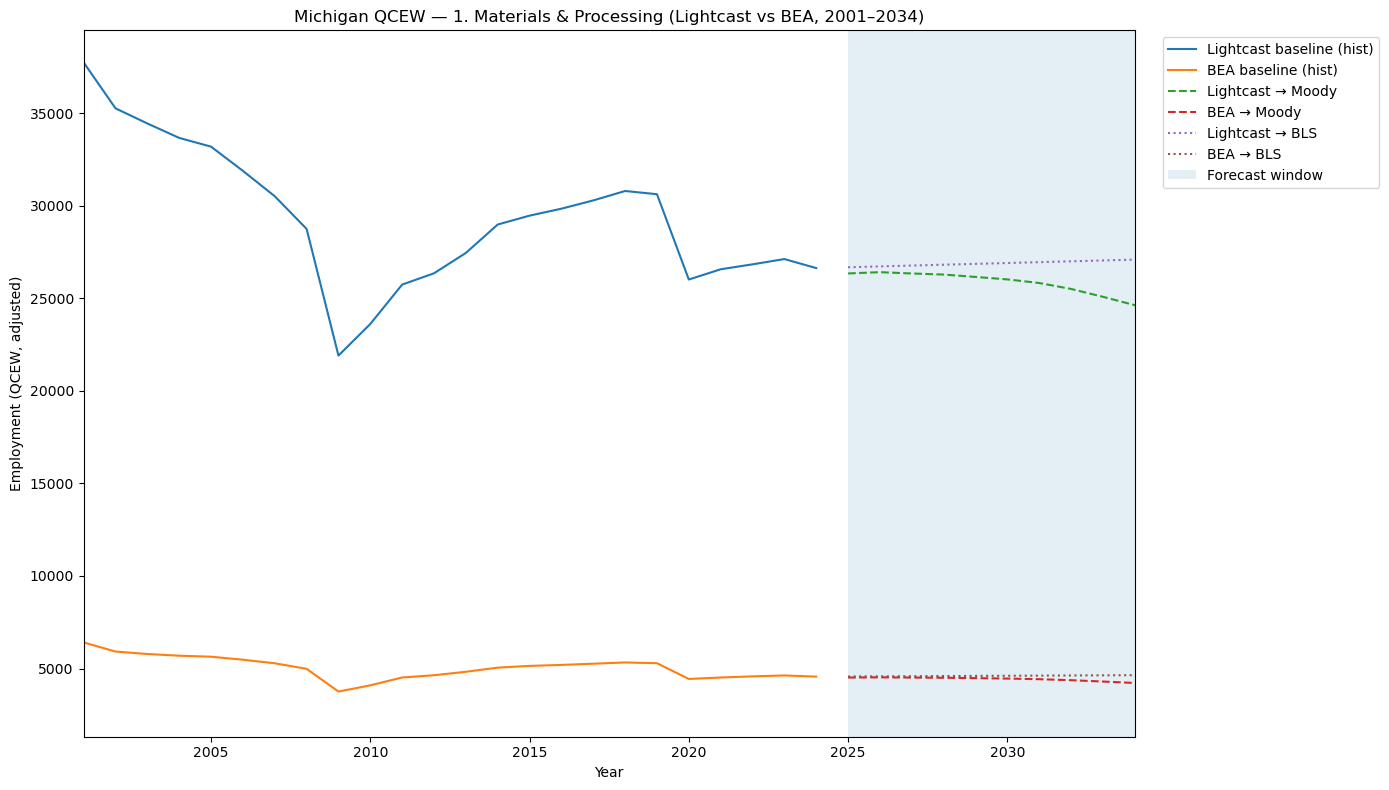

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_compare_segment_2_lightcast_vs_bea_2001_2034.png


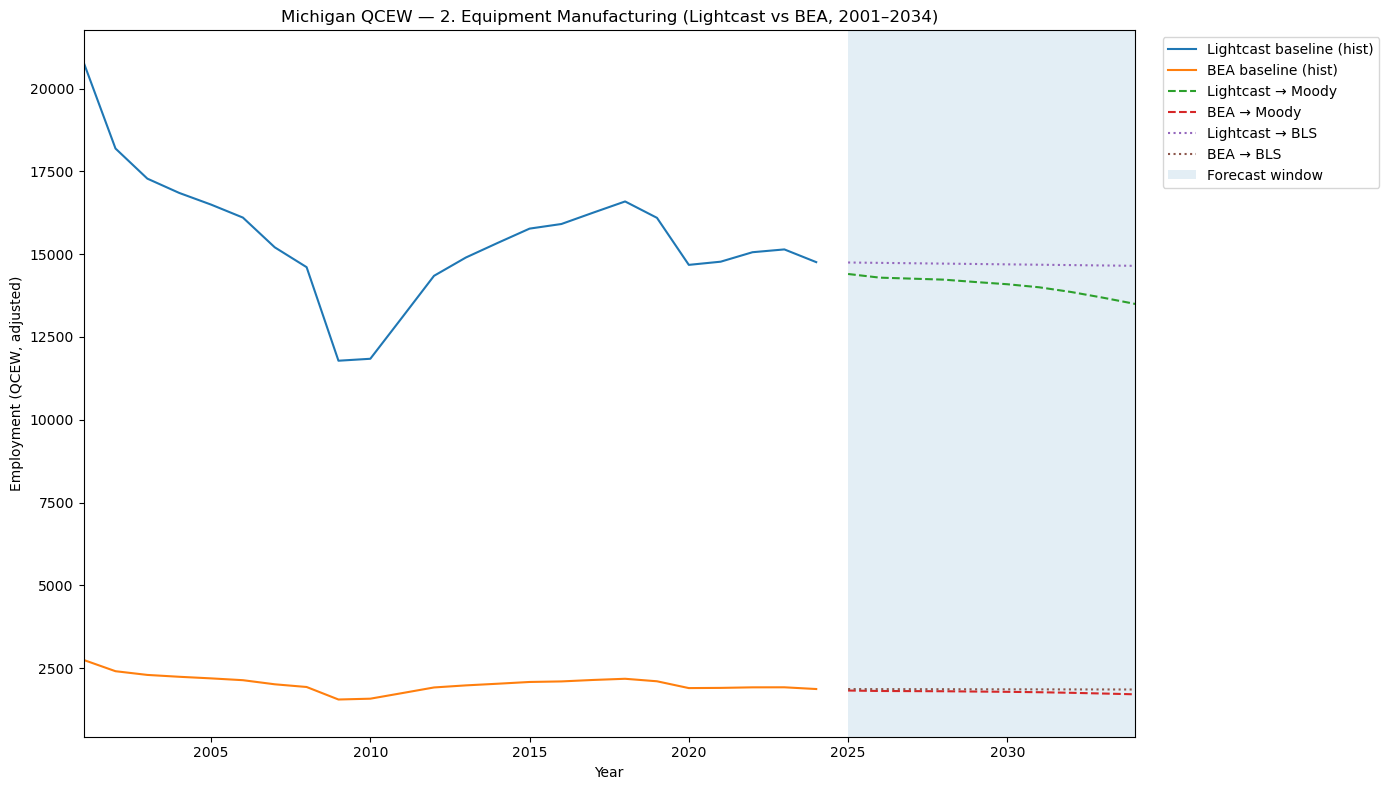

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_compare_segment_3_lightcast_vs_bea_2001_2034.png


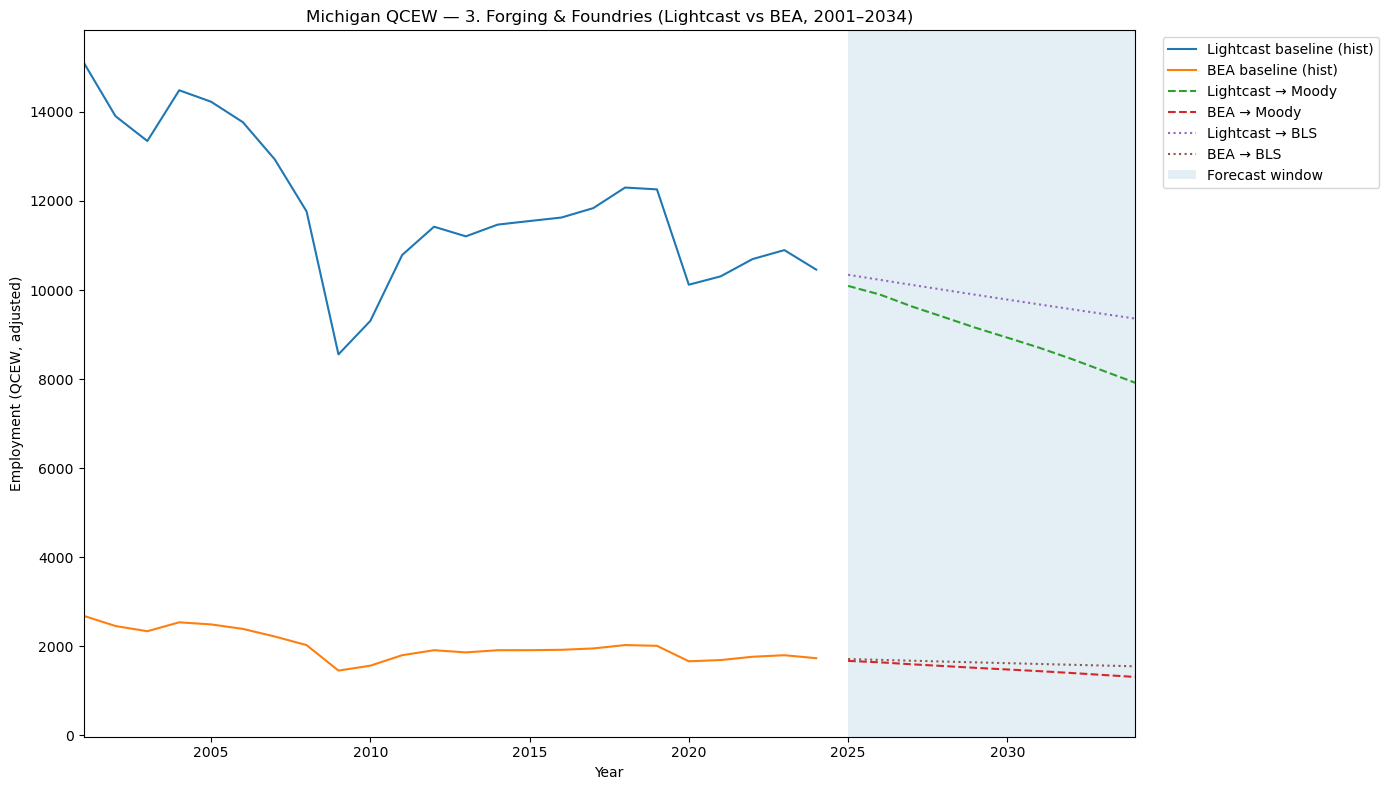

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_compare_segment_4_lightcast_vs_bea_2001_2034.png


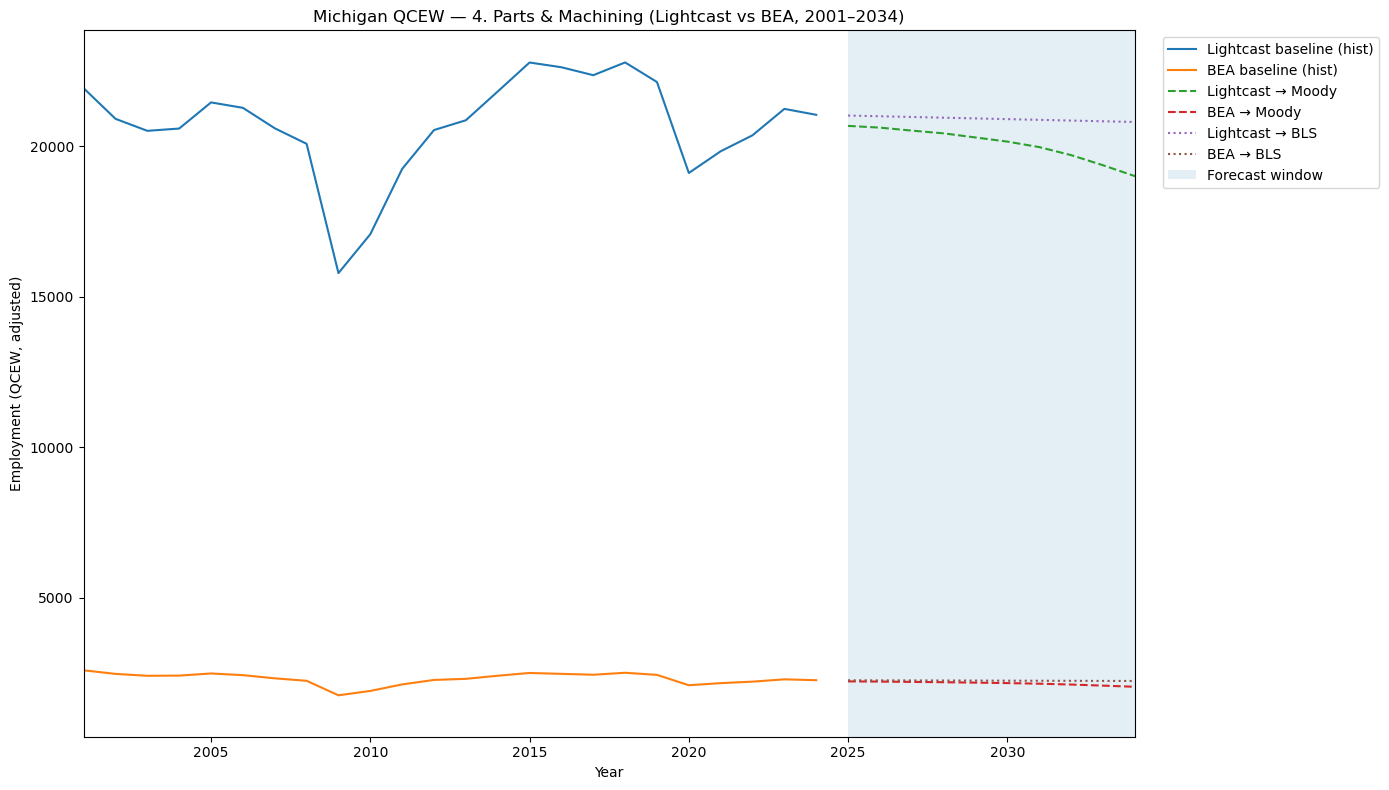

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_compare_segment_5_lightcast_vs_bea_2001_2034.png


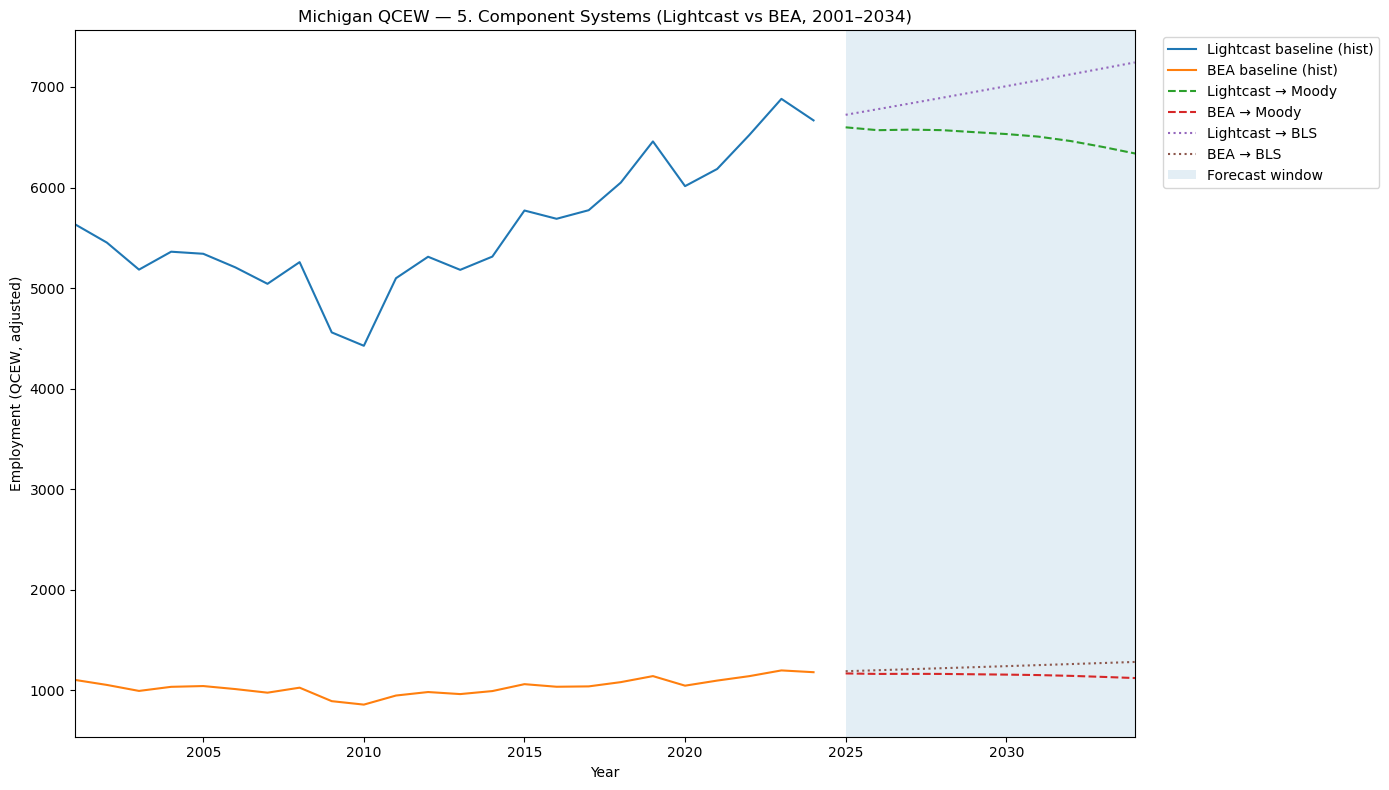

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_compare_segment_6_lightcast_vs_bea_2001_2034.png


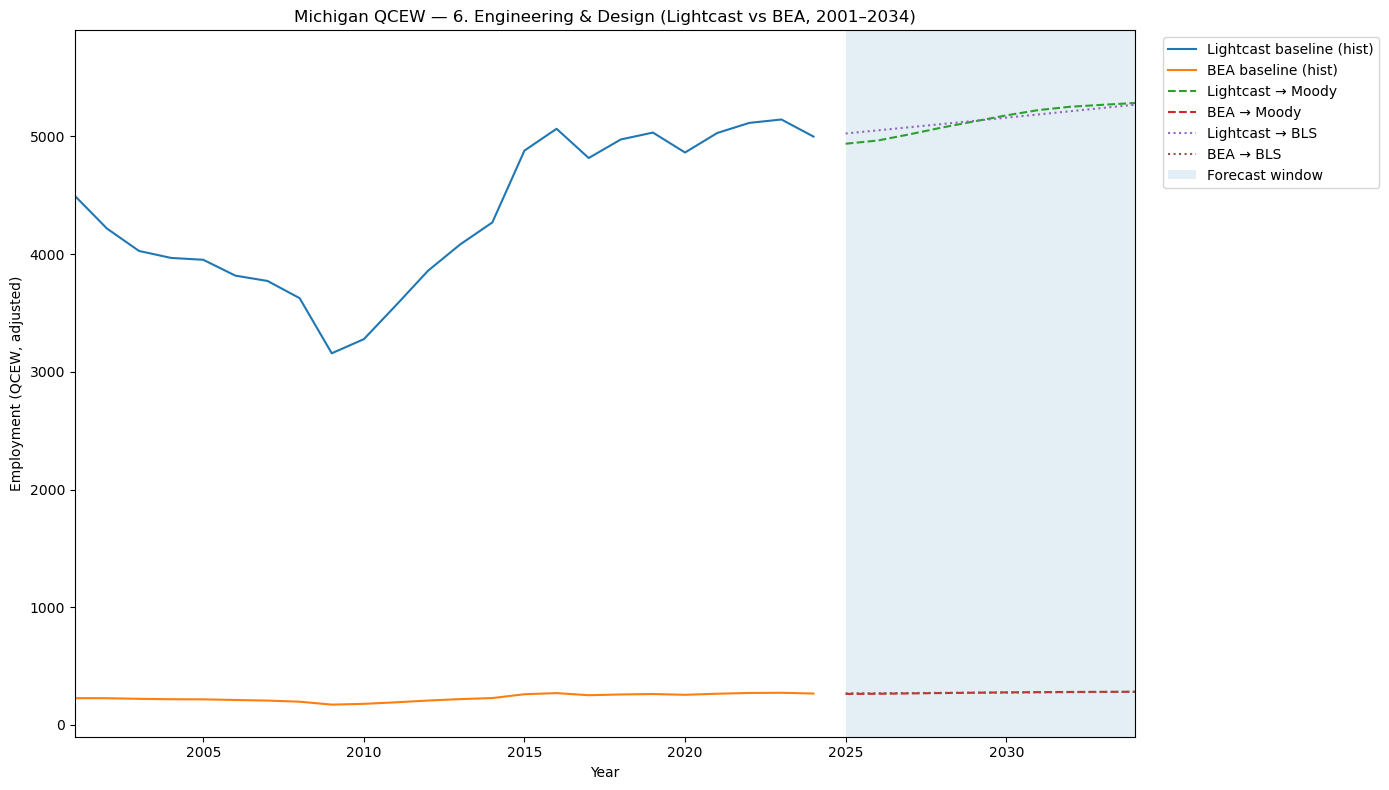

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_compare_segment_7_lightcast_vs_bea_2001_2034.png


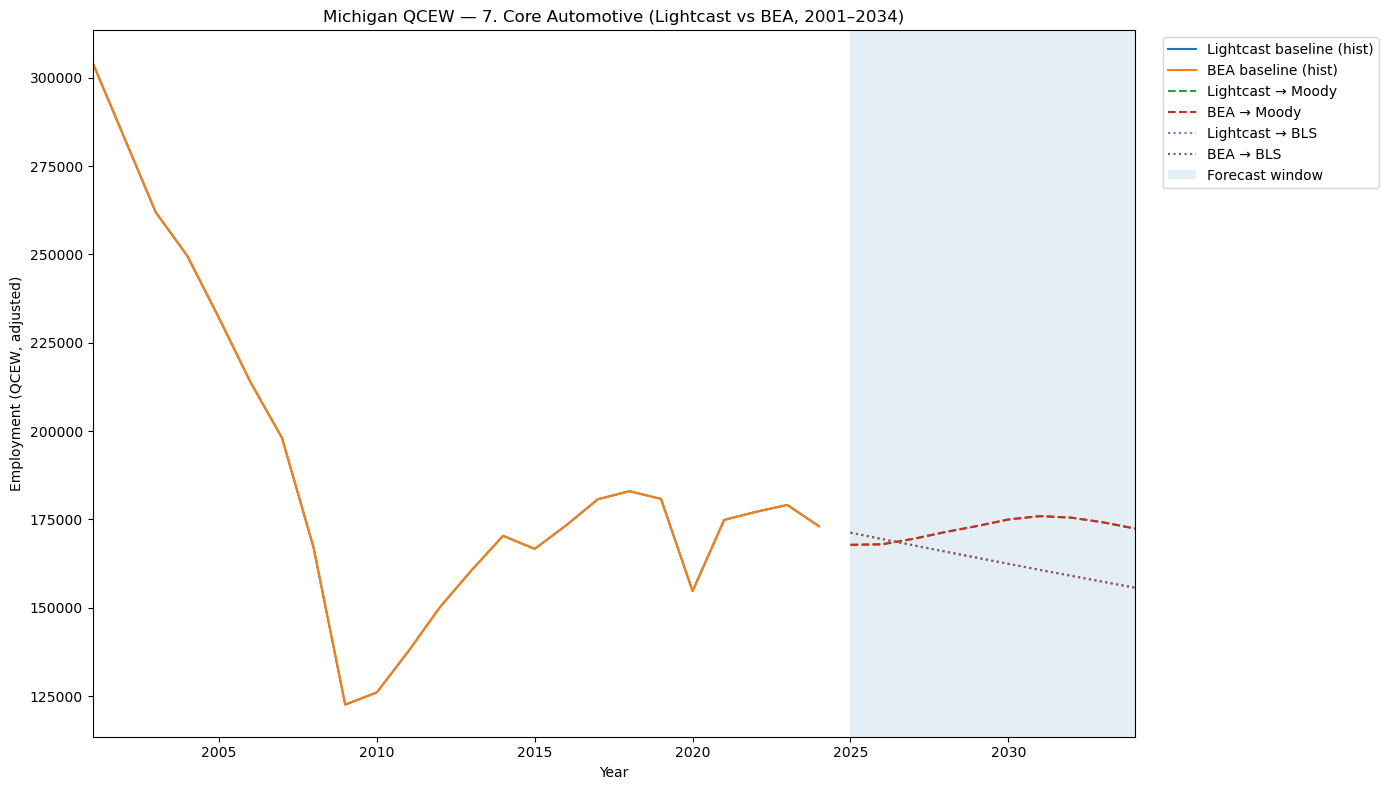

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_compare_segment_8_lightcast_vs_bea_2001_2034.png


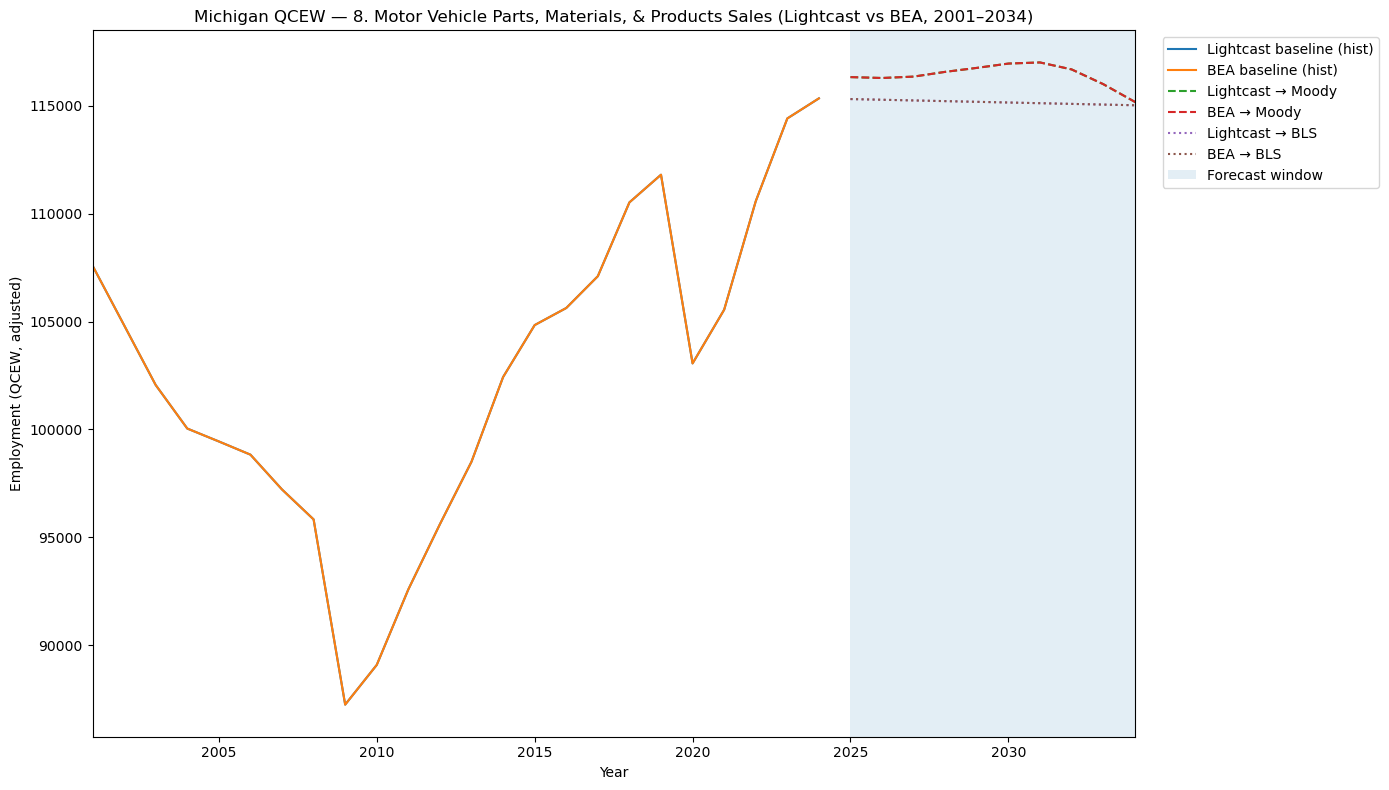

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_compare_segment_9_lightcast_vs_bea_2001_2034.png


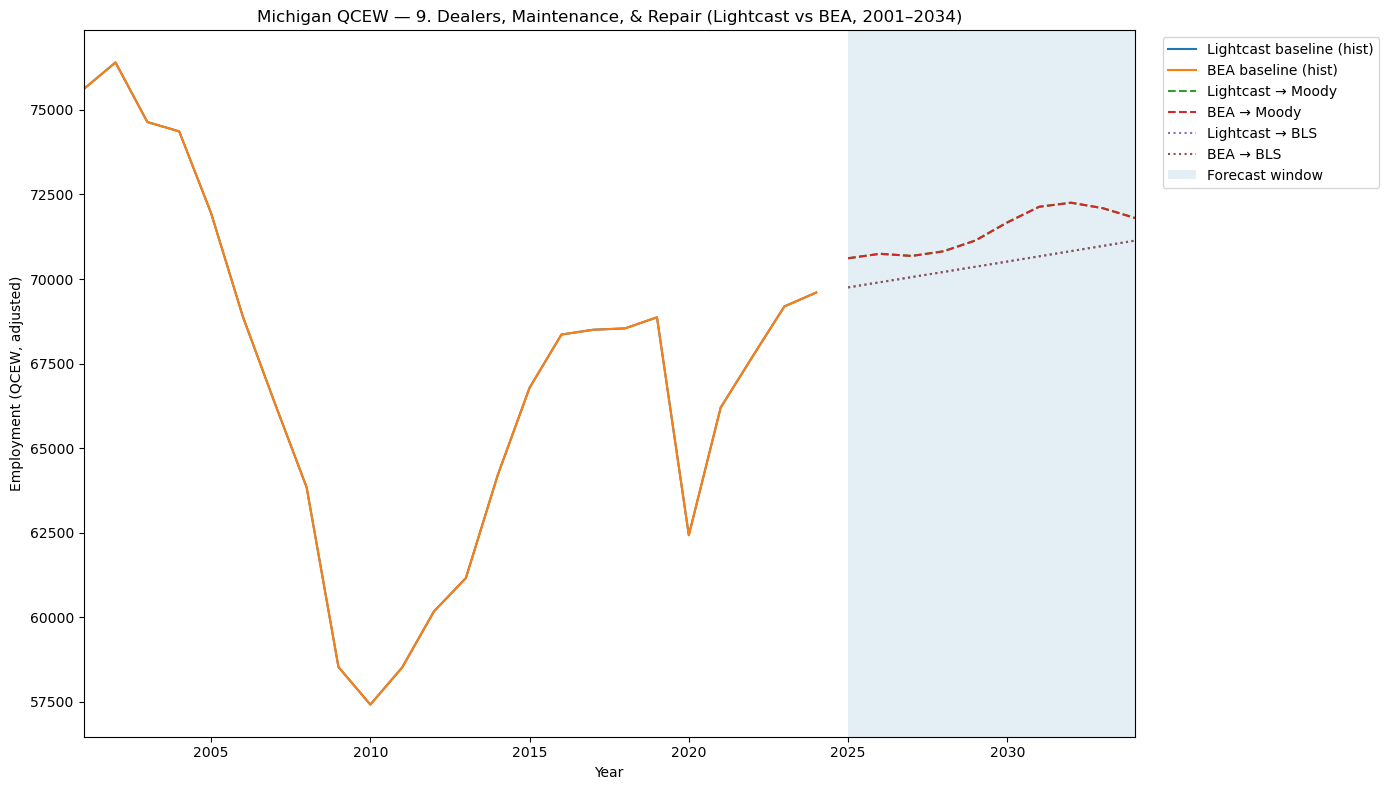

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_compare_segment_10_lightcast_vs_bea_2001_2034.png


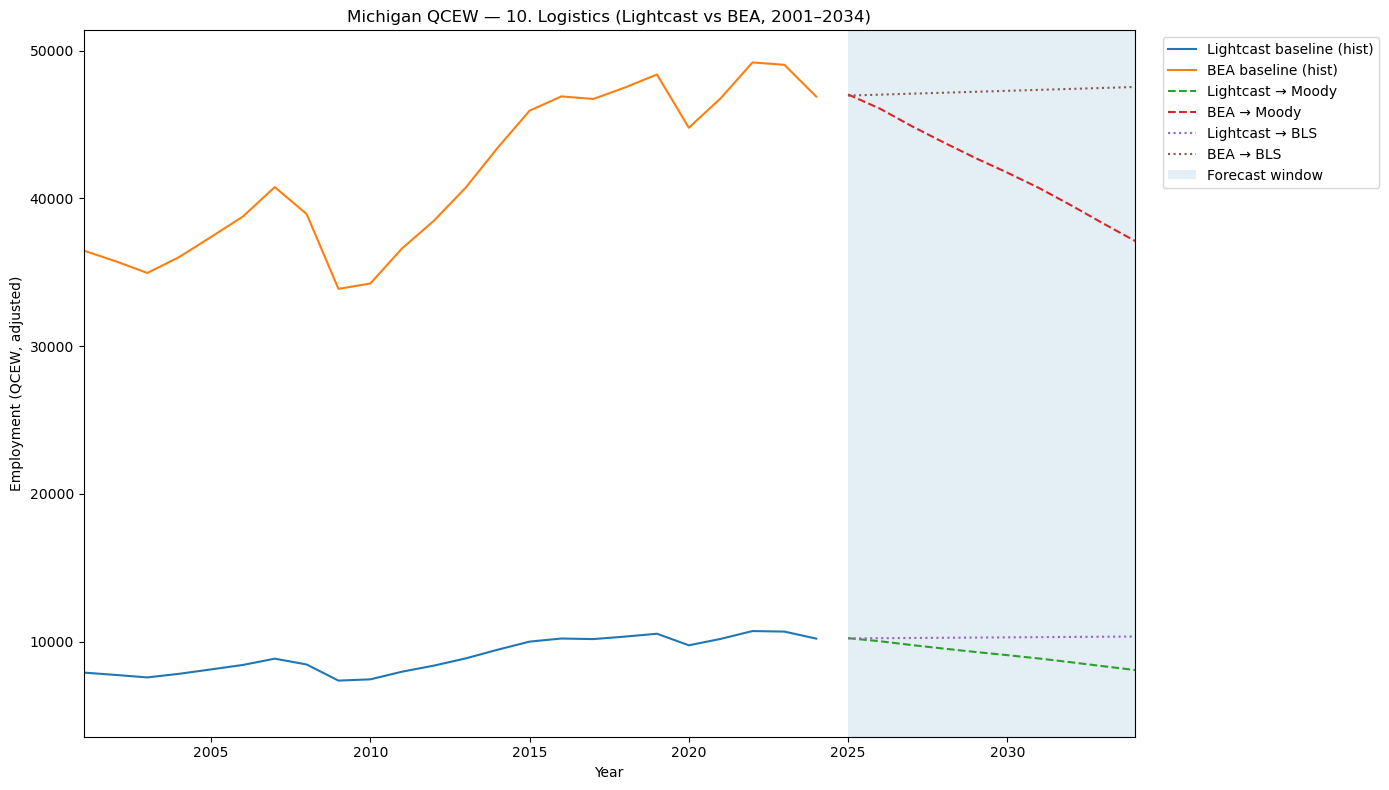

In [4]:

def plot_segment_compare(seg_id: int, seg_label: str):
    lc_hist  = one_point_per_year(lc_seg_base[lc_seg_base["segment_id"].eq(seg_id)], ["segment_id"])
    bea_hist = one_point_per_year(bea_seg_base[bea_seg_base["segment_id"].eq(seg_id)], ["segment_id"])

    lc_cmp = lc_seg_cmp[lc_seg_cmp["segment_id"].eq(seg_id)]
    lc_moody = one_point_per_year(lc_cmp[(lc_cmp["value_type"]=="Forecast") & (lc_cmp["forecast_source"]=="Moody")], ["segment_id"]) if not lc_cmp.empty else pd.DataFrame()
    lc_bls   = one_point_per_year(lc_cmp[(lc_cmp["value_type"]=="Forecast") & (lc_cmp["forecast_source"]=="BLS")],   ["segment_id"]) if not lc_cmp.empty else pd.DataFrame()

    bea_cmp = bea_seg_cmp[bea_seg_cmp["segment_id"].eq(seg_id)]
    bea_moody = one_point_per_year(bea_cmp[(bea_cmp["value_type"]=="Forecast") & (bea_cmp["forecast_source"]=="Moody")], ["segment_id"]) if not bea_cmp.empty else pd.DataFrame()
    bea_bls   = one_point_per_year(bea_cmp[(bea_cmp["value_type"]=="Forecast") & (bea_cmp["forecast_source"]=="BLS")],   ["segment_id"]) if not bea_cmp.empty else pd.DataFrame()

    fig, ax = plt.subplots(figsize=(14,8))
    if not lc_hist.empty:  ax.plot(lc_hist["year"],  lc_hist["employment_qcew"],  label="Lightcast baseline (hist)")
    if not bea_hist.empty: ax.plot(bea_hist["year"], bea_hist["employment_qcew"], label="BEA baseline (hist)")
    if not lc_moody.empty:  ax.plot(lc_moody["year"],  lc_moody["employment_qcew"],  linestyle="--", label="Lightcast → Moody")
    if not bea_moody.empty: ax.plot(bea_moody["year"], bea_moody["employment_qcew"], linestyle="--", label="BEA → Moody")
    if not lc_bls.empty:  ax.plot(lc_bls["year"],  lc_bls["employment_qcew"],  linestyle=":", label="Lightcast → BLS")
    if not bea_bls.empty: ax.plot(bea_bls["year"], bea_bls["employment_qcew"], linestyle=":", label="BEA → BLS")

    starts = [s for s in (forecast_start(lc_cmp), forecast_start(bea_cmp)) if s is not None]
    if starts:
        fstart = max(min(starts), YR_MIN)
        ax.axvspan(fstart, YR_MAX, alpha=0.12, zorder=0)
        from matplotlib.patches import Patch
        handles, labels = ax.get_legend_handles_labels()
        handles.append(Patch(alpha=0.12, label="Forecast window")); labels.append("Forecast window")
        ax.legend(handles, labels, bbox_to_anchor=(1.02,1), loc="upper left")
    else:
        ax.legend(bbox_to_anchor=(1.02,1), loc="upper left")

    ax.set_xlim(YR_MIN, YR_MAX)
    ax.set_xlabel("Year"); ax.set_ylabel("Employment (QCEW, adjusted)")
    ax.set_title(f"Michigan QCEW — {seg_label} (Lightcast vs BEA, 2001–2034)")
    fig.tight_layout()
    out = FIG_DIR / f"mi_qcew_compare_segment_{seg_id}_lightcast_vs_bea_2001_2034.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    print("Saved:", out)
    plt.show(); plt.close(fig)

labels_lc  = lc_seg_base.sort_values(["segment_id","year"]).groupby("segment_id")["segment_name"].first()
labels_bea = bea_seg_base.sort_values(["segment_id","year"]).groupby("segment_id")["segment_name"].first()
all_ids = sorted(set(labels_lc.index).union(set(labels_bea.index)))
for seg_id in all_ids:
    label = labels_lc.get(seg_id, labels_bea.get(seg_id, f"Segment {seg_id}"))
    plot_segment_compare(int(seg_id), str(label))
